In [1]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
import cv2
import matplotlib.pyplot as plt

In [2]:
# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [36]:
image= "A_1.jpg"
resolution = 0.064583333
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)
maxscale= width*resolution / 8

x= 0
verbose = 1

Stage 1: read image

In [37]:
im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

Stage 2: Denoised image using default parameters of `denoise_wavelet`

In [38]:
filter=False

if filter:
    sigma_est = estimate_sigma(im, multichannel=False, average_sigmas=True)
    region = denoise_wavelet(im, multichannel=False, rescale_sigma=True,
                                method='VisuShrink', mode='soft', sigma=sigma_est*2)
else:
    region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape

Stage 3: Call cwt to get particle size distribution

In [39]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3, np.maximum(nx,ny)/maxscale, 1),  'morl' , .5)
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

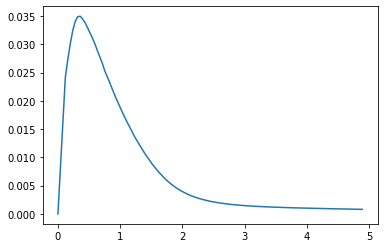

In [40]:
p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

plt.plot((scales*resolution), r_v)
plt.show()

[0.15674079 0.22121562 0.29171362 0.39458442 0.45373314 0.72272223
 1.24810438 1.60751499 2.07910166 3.0081024 ]


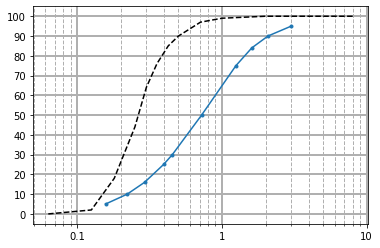

In [43]:
pd = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
print(data_C)
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
percentile_C = [5, 10, 16, 25, 30, 50,  75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_A, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

Stage 5: Calc particle size stats

In [ ]:
pd = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
pd *= resolution
if verbose==1:
    print("d50 = "+str(pd[5]))

mnsz = np.sum(r_v*scales)
if verbose==1:
    print("mean size = "+str(mnsz))

srt = np.sqrt(np.sum(r_v*((scales-mnsz)**2)))
if verbose==1:
    print("stdev = "+str(srt))

sk = (sum(r_v*((scales-mnsz)**3)))/(100*srt**3)
if verbose==1:
    print("skewness = "+str(sk))

kurt = (sum(r_v*((scales-mnsz)**4)))/(100*srt**4)
if verbose==1:
    print("kurtosis = "+str(kurt))


Stage 6: Return a dict object of stats

In [ ]:
print( {'mean grain size': mnsz, 'grain size sorting': srt, 'grain size skewness': sk, 'grain size kurtosis': kurt, 
        'percentiles': [.05,.1,.16,.25,.3,.5,.75,.84,.9,.95], 'percentile_values': pd, 'grain size frequencies': r_v, 'grain size bins': scales})

In [45]:
print(r_v)


[0.         0.02417734 0.02736029 0.03009593 0.0324455  0.03406155
 0.03489174 0.03496878 0.03447214 0.03381161 0.03292858 0.03196394
 0.03105083 0.03001356 0.02883297 0.0277121  0.02655154 0.02524921
 0.02419566 0.02314572 0.02204387 0.02097599 0.01996857 0.01899349
 0.01801913 0.01709296 0.01621134 0.01536014 0.01452351 0.01366055
 0.01292707 0.01219805 0.01148108 0.01076434 0.01012706 0.009493
 0.00887356 0.00831907 0.00778752 0.00726982 0.00682068 0.0063473
 0.00593352 0.00554766 0.00519341 0.00486492 0.00455589 0.00427778
 0.00402423 0.00379404 0.00356901 0.00336374 0.00319546 0.00302526
 0.00287984 0.0027363  0.00261895 0.00250026 0.00238932 0.00229179
 0.00218042 0.00212389 0.002034   0.00196479 0.00190493 0.0018384
 0.0017838  0.00173016 0.00168292 0.00164062 0.0015979  0.00155967
 0.00152202 0.00148671 0.0014559  0.00142217 0.00139651 0.00137151
 0.00134692 0.00132313 0.00129841 0.00127886 0.00126033 0.00124423
 0.00122179 0.00120482 0.00118777 0.00117149 0.0011561  0.00114226